# Importy

In [1]:
# link to google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from skimage import color
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Dropout

from concurrent.futures import ThreadPoolExecutor

# Obrobka zdjec

In [14]:
def generate_mask(image_path):
    mask_path = image_path.replace('.jpg', '_mask.jpg')
    if not os.path.exists(mask_path) and '_mask.jpg' not in image_path:  # Sprawdzanie, czy maska już istnieje
        image = cv2.imread(image_path)

        blurred = cv2.medianBlur(image, 11)

        gray_image = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, [7, 7])
        closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

        segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

        cv2.imwrite(mask_path, segmented_image)

In [5]:
def preprocess_image(image, target_size):
    # Konwersja do przestrzeni kolorów RGB
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    denoised_image = cv2.medianBlur(rgb_img, 11)

    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

    segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

    sobel_x = cv2.Sobel(segmented_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(segmented_image, cv2.CV_64F, 0, 1, ksize=3)
    edge_image = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

    # Skalowanie do docelowej rozdzielczości
    image = cv2.resize(edge_image, target_size)

    # Normalizacja wartości pikseli do zakresu [0, 1]
    image = image / 255.0

    return image

In [6]:
def preprocess_mask(mask, target_size, threshold=150):
    # Skalowanie do docelowej rozdzielczości
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Normalizacja wartości pikseli do zakresu [0, 1]
    mask = (mask > threshold) * 255

    return mask

In [7]:
def load_image(image_path, target_size):
    image = cv2.imread(image_path)
    return preprocess_image(image, target_size)

In [8]:
def load_mask(mask_path, target_size, threshold=150):
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        return preprocess_mask(mask, target_size, threshold)[..., np.newaxis]
    else:
        return np.zeros((target_size[0], target_size[1], 1), dtype=np.uint8)

In [9]:
def load_data(data_folder, target_size=(256, 256)):
    images = []
    masks = []

    with ThreadPoolExecutor() as executor:
        for filename in os.listdir(data_folder):
            if filename.endswith('.jpg'):
                image_path = os.path.join(data_folder, filename)
                mask_path = image_path.replace('.jpg', '_mask.jpg')

                generate_mask(image_path)

                # Sprawdź, czy to obraz czy maska
                is_mask = '_mask' in filename

                if is_mask:
                    mask_future = executor.submit(load_mask, image_path, target_size)
                    masks.append(mask_future.result())
                else:
                    generate_mask(image_path)
                    image_future = executor.submit(load_image, image_path, target_size)
                    images.append(image_future.result())

                image_future = executor.submit(load_image, image_path, target_size)
                mask_future = executor.submit(load_mask, mask_path, target_size)

    return np.array(images), np.array(masks)

## test maski i funkcji wczytywania obrazow

In [171]:
data_folder = 'drive/MyDrive/test_maski'

In [203]:
# Wczytywanie danych
X_train, y_train = load_data(data_folder)

In [213]:
unique_values = np.unique(X_train)

print(unique_values)

[0.00000000e+00 4.31583729e-05 6.90533966e-04 ... 4.46136457e+00
 4.46216477e+00 4.46221812e+00]


In [205]:
print("Kształt X_train:", X_train.shape)
print("Kształt y_train:", y_train.shape)

Kształt X_train: (4, 256, 256)
Kształt y_train: (4, 256, 256, 1)


In [206]:
print(y_train)

[[[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   

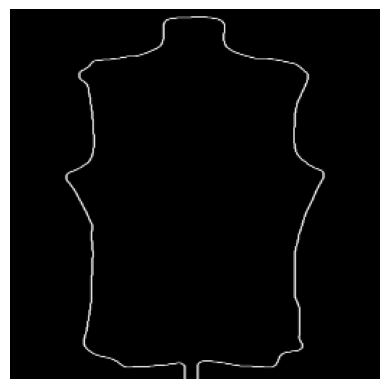

In [208]:
image = X_train[1]

# Wyświetlenie obrazu
plt.imshow(image, cmap='gray')  # cmap='gray' dla obrazów w skali szarości
plt.axis('off')  # Wyłączenie osi
plt.show()

# Model

In [10]:
# Model U-Net
def unet_model(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Conv2D(128, 2, activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Dropout(0.5)(up1)  # Dodaj warstwę Dropout
    merge1 = Concatenate(axis=3)([conv2, up1])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Dropout(0.5)(up2)  # Dodaj warstwę Dropout
    merge2 = Concatenate(axis=3)([conv1, up2])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [38]:
from keras.preprocessing.image import apply_affine_transform, apply_brightness_shift

In [96]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, target_size, augmentations=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.indexes = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_x = self.x[start_idx:end_idx]
        batch_y = self.y[start_idx:end_idx]

        if self.augmentations:
            batch_x, batch_y = self.apply_augmentations(batch_x, batch_y)

        return batch_x, batch_y

    def apply_augmentations(self, batch_x, batch_y):
        augmented_images = []
        augmented_masks = []

        for i in range(len(batch_x)):
            augmented = self.augmentations(image=batch_x[i], mask=batch_y[i])
            aug_image = augmented["image"]
            aug_mask = augmented["mask"]

            augmented_images.append(aug_image)
            augmented_masks.append(aug_mask)

        return np.array(augmented_images), np.array(augmented_masks)


In [95]:
import albumentations as A

In [97]:
def load_data_with_generator(data_folder, target_size=(256, 256), batch_size=32, validation_split=0.2, random_state=42):
    X_train, y_train = load_data(data_folder, target_size)

    # Dodaj trzeci wymiar dla obrazów w skali szarości
    X_train = np.expand_dims(X_train, axis=-1)
    y_train = np.expand_dims(y_train, axis=-1)

    # Podział na dane treningowe i walidacyjne
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, random_state=random_state)

    augmentation_transform = A.Compose([
        A.Rotate(limit=15),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15),
        A.HorizontalFlip(p=0.5),
        # Dodaj inne transformacje według potrzeb
    ], additional_targets={"image": "image", "mask": "image"})  # Dla obrazów w skali szarości

    train_generator = DataGenerator(X_train, y_train, batch_size, target_size, augmentations=augmentation_transform)
    val_generator = DataGenerator(X_val, y_val, batch_size, target_size)  # Bez augmentacji dla danych walidacyjnych

    return train_generator, val_generator

In [98]:
# Generowanie obrazow do nauki
# Rozmiar wejściowy obrazu
input_shape = (256, 256, 1)
data_folder = 'drive/MyDrive/test_maski'
batch_size = 32

# inicjalizacja danych
train_generator, val_generator = load_data_with_generator(data_folder, target_size=(256, 256), batch_size=batch_size)


In [99]:
print("Rozmiar train_generator:")
print(len(train_generator))
print("Rozmiar val_generator:")
print(len(val_generator))

Rozmiar train_generator:
1
Rozmiar val_generator:
1


In [100]:
for batch_x, batch_y in train_generator:
    print("Przykładowe dane z train_generator:")
    print("Rozmiar batch_x:", batch_x.shape)
    print("Rozmiar batch_y:", batch_y.shape)
    break  # Jeśli chcesz wykonać to tylko dla pierwszego batcha

error: ignored

In [23]:
# Przykładowe dane z train_generator
batch_x, batch_y = train_generator[0]  # Pobierz pierwszy batch
batch_x = np.expand_dims(batch_x, axis=-1)
batch_y = np.expand_dims(batch_y, axis=-1)
print("Przykładowe dane z train_generator:")
print("Rozmiar batch_x:", batch_x.shape)
print("Rozmiar batch_y:", batch_y.shape)

# Przykładowe dane z val_generator
batch_x_val, batch_y_val = val_generator[0]  # Pobierz pierwszy batch
batch_x_val = np.expand_dims(batch_x, axis=-1)
batch_y_val = np.expand_dims(batch_y, axis=-1)
print("Przykładowe dane z val_generator:")
print("Rozmiar batch_x_val:", batch_x_val.shape)
print("Rozmiar batch_y_val:", batch_y_val.shape)

ValueError: ignored

In [211]:

# optymalizator
opt = Adam(learning_rate=0.001)

# Inicjalizacja modelu
model = unet_model(input_shape)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Inicjalizacja redukcji learning rate
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)

# Wczesne zatrzymanie
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Trenowanie modelu
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping, lr_reducer])

FileNotFoundError: ignored

In [ ]:
# Rozmiar wejściowy obrazu
input_shape = (256, 256, 3)

# Podział danych na zbiór treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Skalowanie wartosci obrazu na 0 i 1
X_train = X_train / 255.0
X_val = X_val / 255.0

# Inicjalizacja generatora danych
batch_size = 16
target_size = (256, 256)
train_generator = DataGenerator(X_train, y_train, batch_size, target_size, augmentations=train_augmentations)
val_generator = DataGenerator(X_val, y_val, batch_size, target_size, augmentations=train_augmentations)  # Generator dla danych walidacyjnych

# optymalizator
opt = Adam(learning_rate=0.001)

# Inicjalizacja modelu
model = unet_model(input_shape)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Inicjalizacja redukcji learning rate
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)

# Wczesne zatrzymanie
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Trenowanie modelu
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping, lr_reducer])

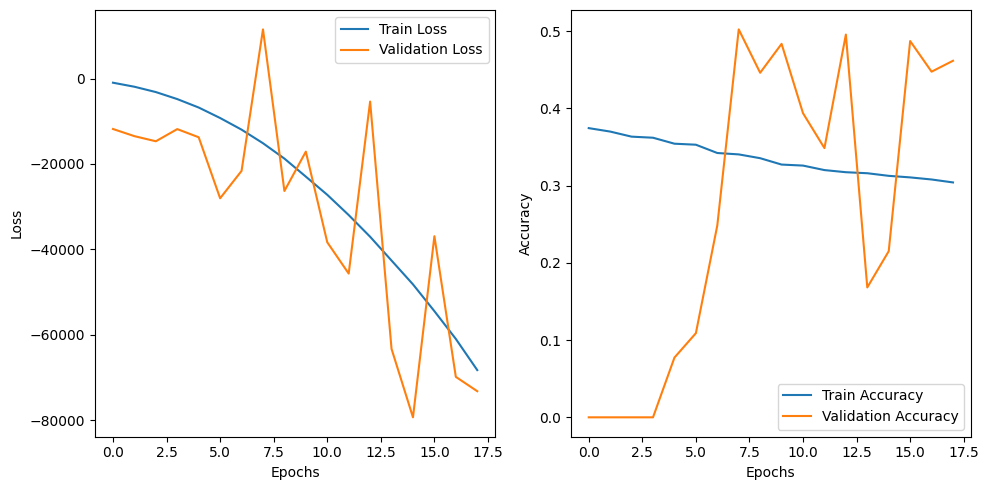

In [8]:
import matplotlib.pyplot as plt

# Wydobycie historii metryk
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Wykres straty
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
save_folder = 'drive/MyDrive/wytrenowane_modele/small_koszulki'

In [ ]:
model.save(save_folder)

# Sprawdzenie dzialania

In [9]:
polaczone_zdjecie = 'drive/MyDrive/test_maski/koszulka.jpg'

spodnie_folder = 'drive/MyDrive/wytrenowane_modele/small_koszulki'

In [ ]:
from tensorflow.keras.models import load_model

model_spodnie = load_model(spodnie_folder)

OSError: ignored

In [10]:
# Wczytanie obrazu i przetworzenie go
image = cv2.imread(polaczone_zdjecie)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))  # Dostosuj do rozmiaru wejścia modelu

# Przygotowanie obrazu do predykcji (dodanie jednego wymiaru)
image = np.expand_dims(image, axis=0)

In [ ]:
prediction_mask = model_spodnie.predict(image)

1/1 [==============================] - 0s 21ms/step


In [11]:
pred = model.predict(image)

1/1 [==============================] - 0s 331ms/step


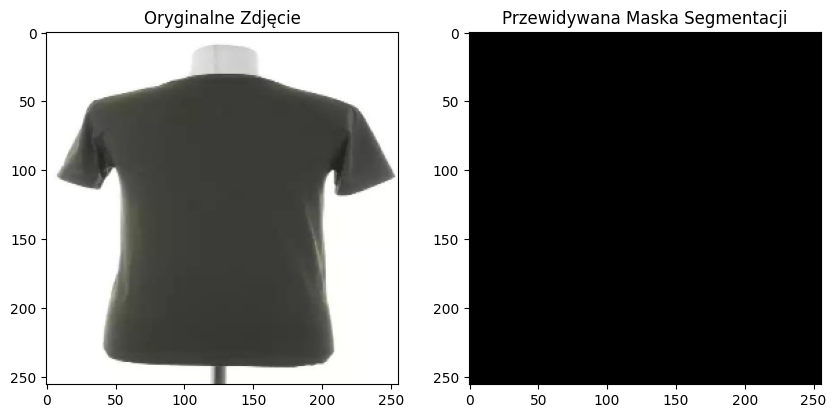

In [12]:
import matplotlib.pyplot as plt

# Przewidywanie maski dla zbiorowego zdjęcia
binary_mask = pred > 0.1  # Próg dla przekształcenia mapy prawdopodobieństwa na binarną maskę

# Wizualizacja
plt.figure(figsize=(10, 5))

# Wyświetlenie oryginalnego zbiorowego zdjęcia
plt.subplot(1, 2, 1)
plt.imshow(image[0])  # Wybieramy pierwszy element, aby uzyskać sam obraz
plt.title("Oryginalne Zdjęcie")

# Wyświetlenie przewidywanej maski
plt.subplot(1, 2, 2)
plt.imshow(binary_mask[0].squeeze(), cmap='gray')  # Squeeze usuwa zbędny wymiar
plt.title("Przewidywana Maska Segmentacji")

plt.show()

# lepsze zrozumiene progowania

In [ ]:
import argparse
import cv2


In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str, required=True,
	help="path to input image")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -i IMAGE
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: ignored

In [ ]:
from google.colab.patches import cv2_imshow

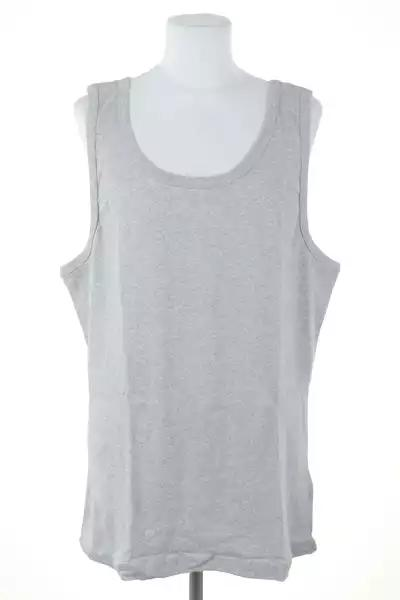

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# Wczytaj obraz
image = cv2.imread(polaczone_zdjecie)

# Wyświetl obraz za pomocą cv2_imshow
cv2_imshow(image)
# convert the image to grayscale and blur it slightly
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

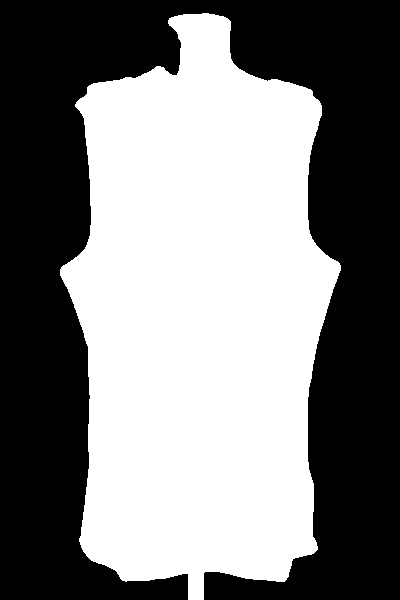

-1

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
# apply simple thresholding with a hardcoded threshold value
(T, threshInv) = cv2.threshold(blurred, 230, 255,
	cv2.THRESH_BINARY_INV)
cv2_imshow(threshInv)
cv2.waitKey(0)

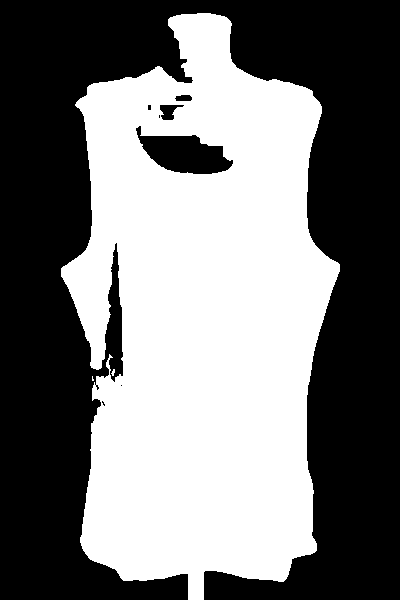

-1

In [ ]:
mask = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 10)

cv2_imshow(mask)
cv2.waitKey(0)

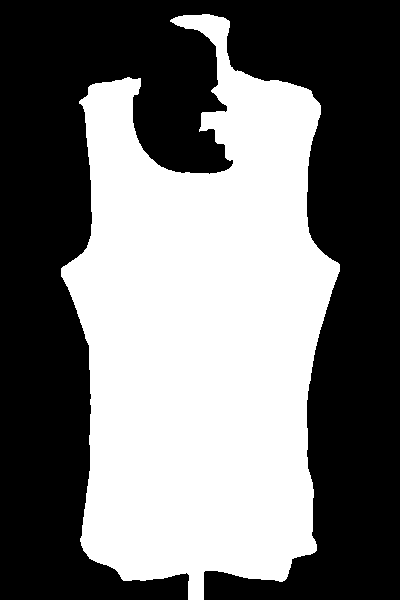

-1

In [ ]:
# apply Otsu's automatic thresholding
(T, threshInv) = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
cv2_imshow(threshInv)
cv2.waitKey(0)

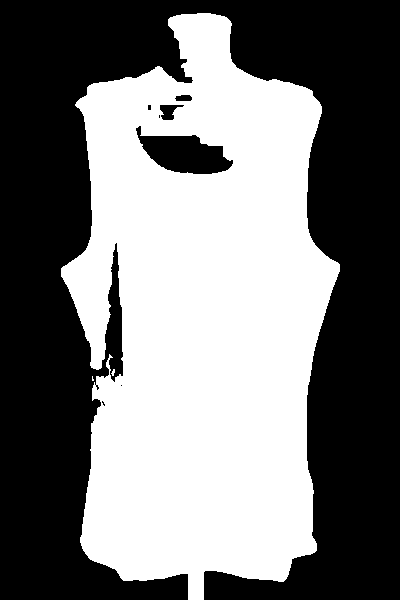

-1

In [ ]:
# instead of manually specifying the threshold value, we can use
# adaptive thresholding to examine neighborhoods of pixels and
# adaptively threshold each neighborhood
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 10)
cv2_imshow(thresh)
cv2.waitKey(0)

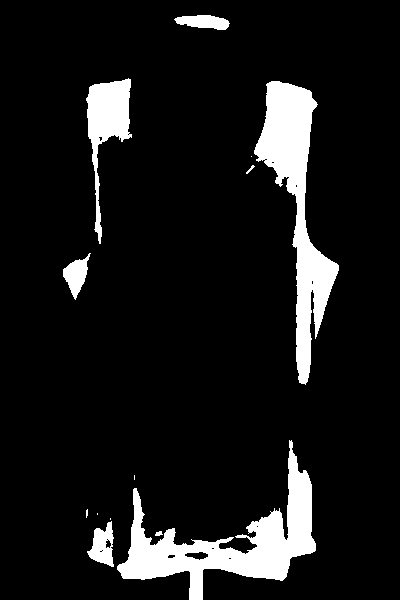

-1

In [ ]:
# perform adaptive thresholding again, this time using a Gaussian
# weighting versus a simple mean to compute our local threshold
# value
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 401, 30)
cv2_imshow(thresh)
cv2.waitKey(0)

# Operacje morfologiczne

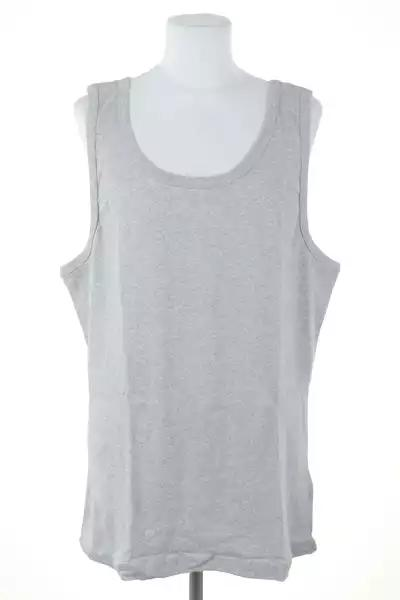

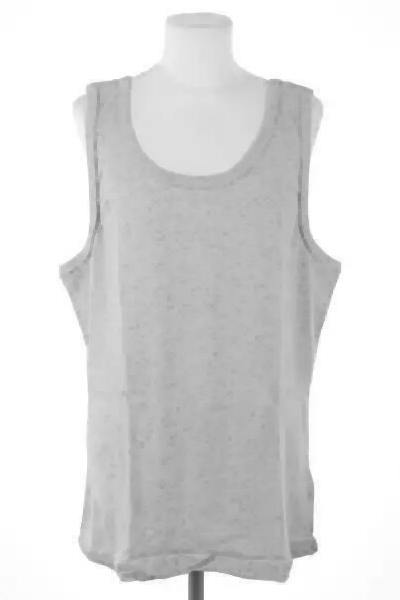

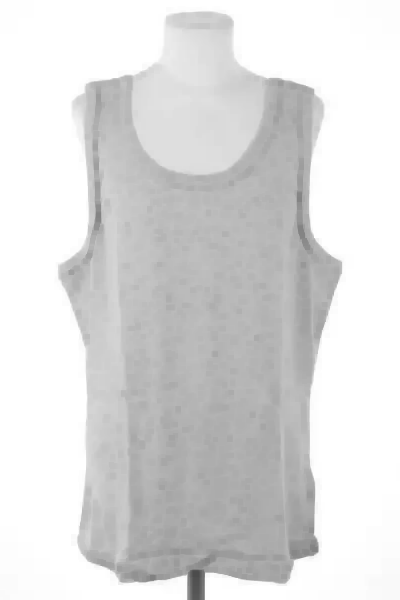

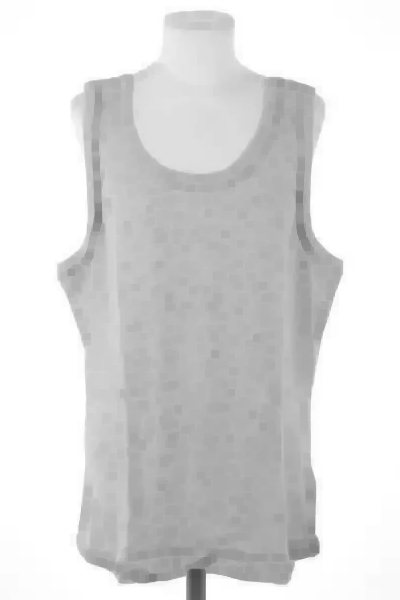

In [ ]:
# Erozja
# load the image, convert it to grayscale, and display it to our
# screen
image = cv2.imread(polaczone_zdjecie)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)
# apply a series of erosions
for i in range(0, 3):
	eroded = cv2.erode(gray.copy(), None, iterations=i + 1)
	cv2_imshow(eroded)
	cv2.waitKey(0)

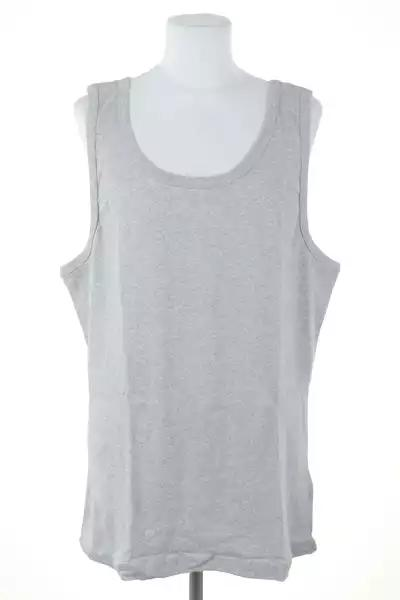

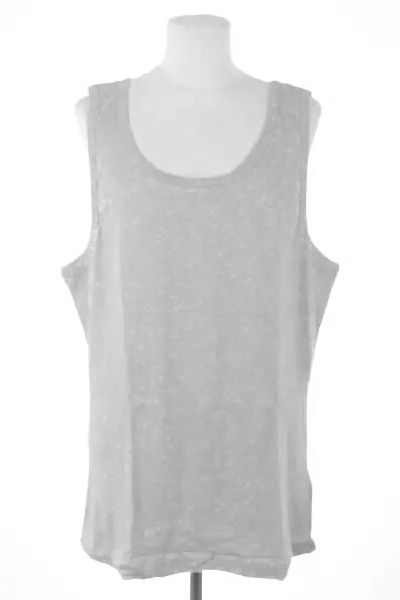

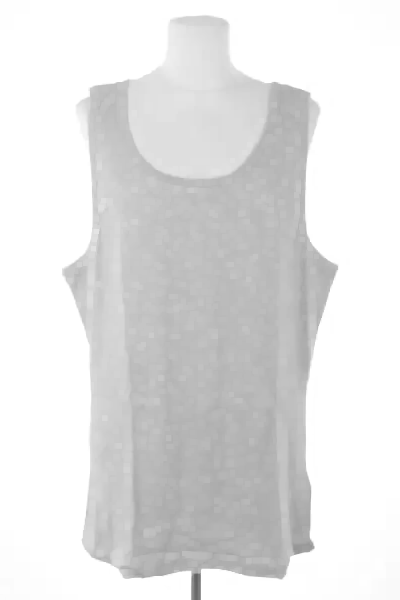

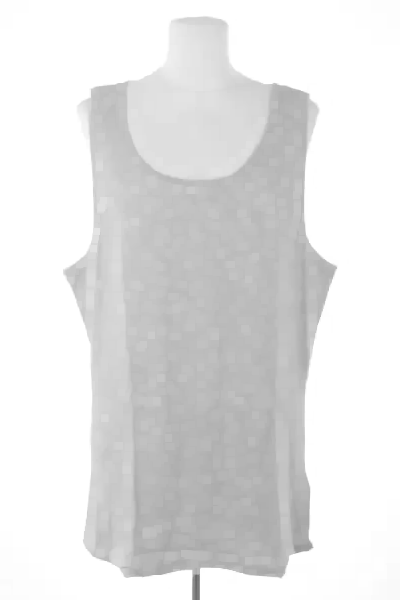

In [ ]:
# Dylatacja
# close all windows to cleanup the screen

cv2_imshow(image)
# apply a series of dilations
for i in range(0, 3):
	dilated = cv2.dilate(gray.copy(), None, iterations=i + 1)
	cv2_imshow(dilated)
	cv2.waitKey(0)

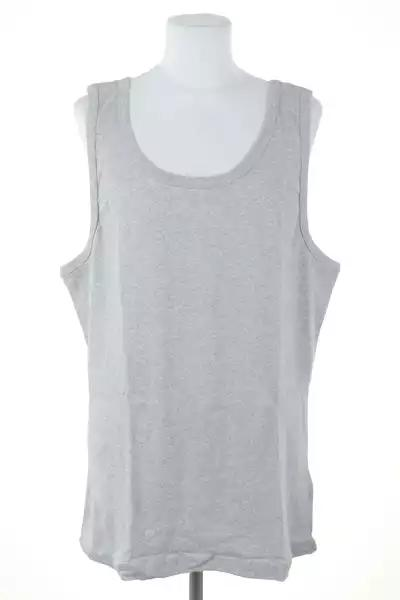

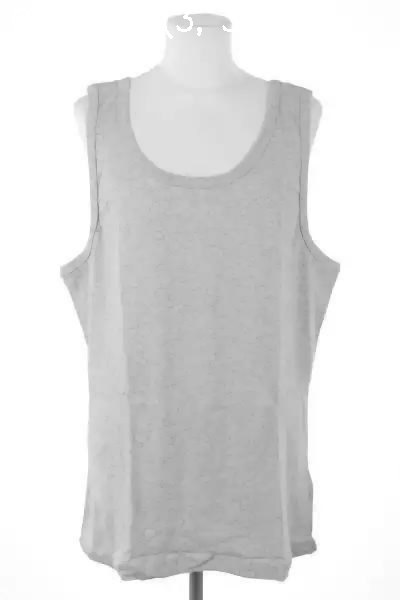

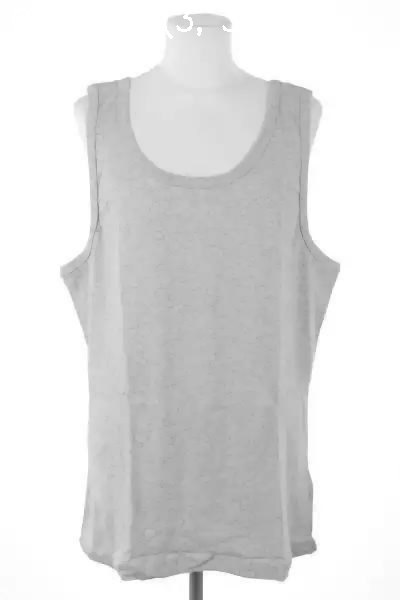

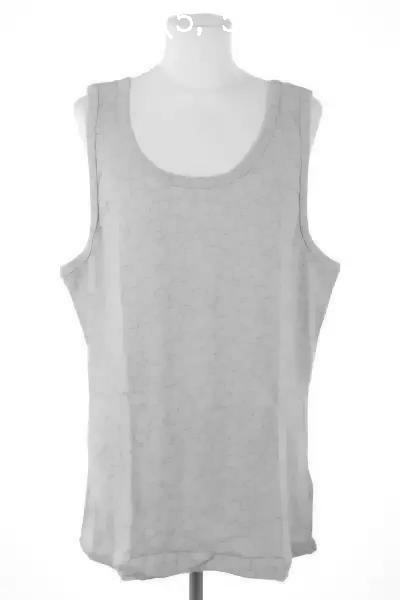

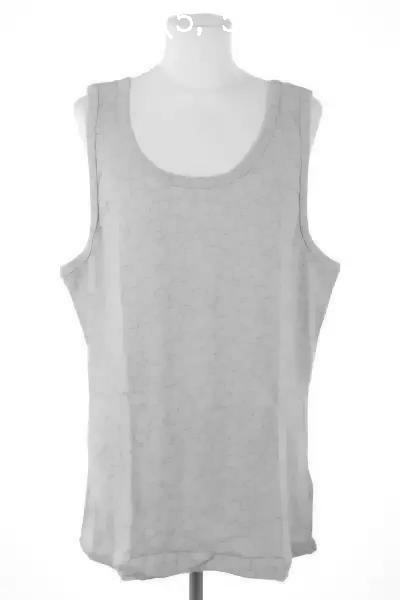

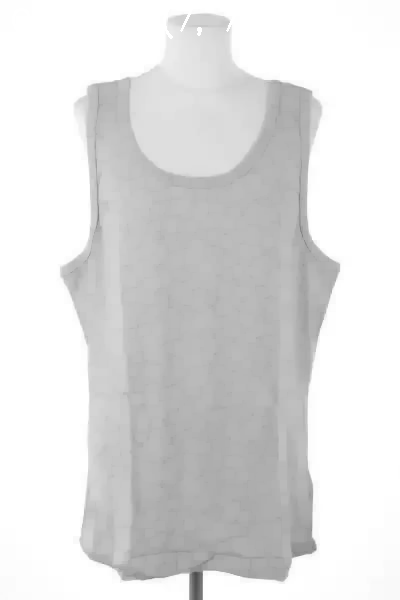

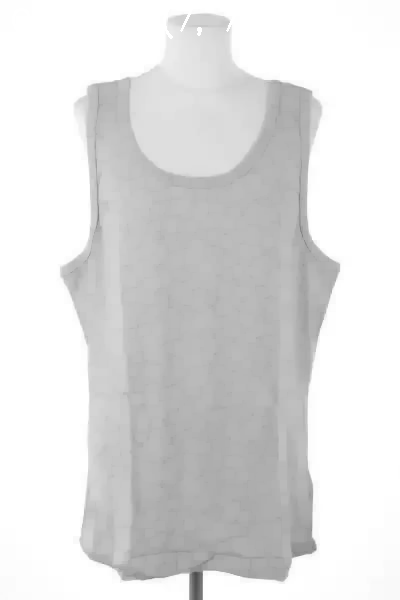

In [ ]:
# close all windows to cleanup the screen, then initialize a list of
# of kernels sizes that will be applied to the image

cv2_imshow(image)
kernelSizes = [(3, 3), (5, 5), (7, 7)]
# loop over the kernels sizes

# Pętla po rozmiarach kerneli
for kernelSize in kernelSizes:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

    # Wyświetl obrazy przy użyciu cv2_imshow
    cv2_imshow(cv2.putText(
        opening,
        f"Opening: ({kernelSize[0]}, {kernelSize[1]})",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2)
    )

    cv2_imshow(opening)

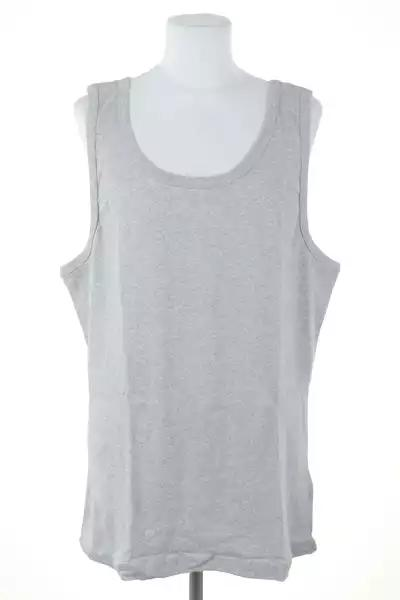

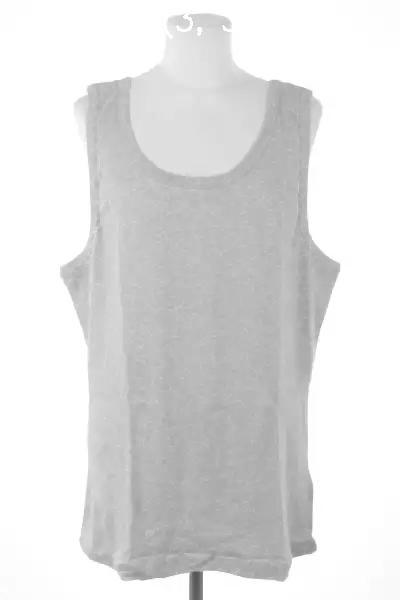

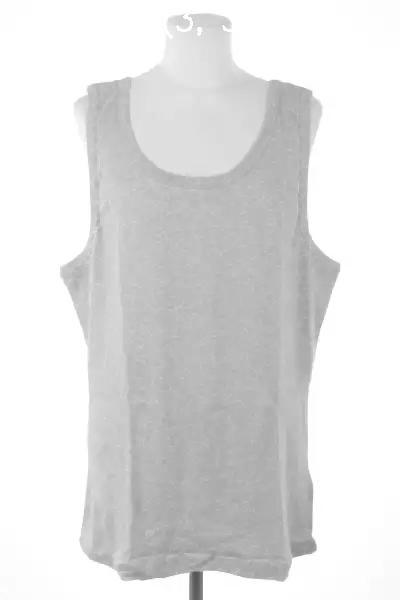

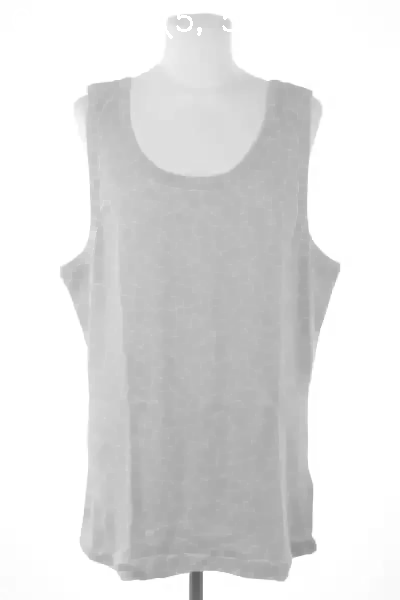

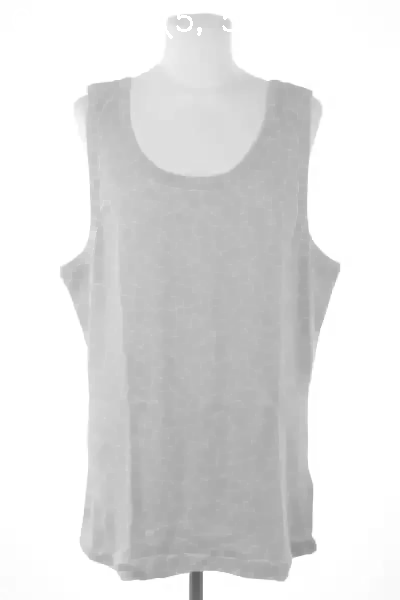

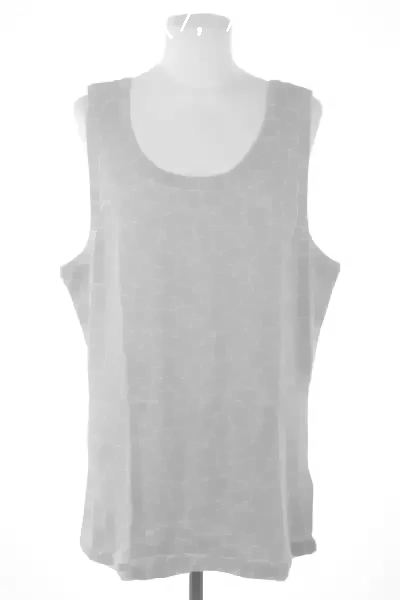

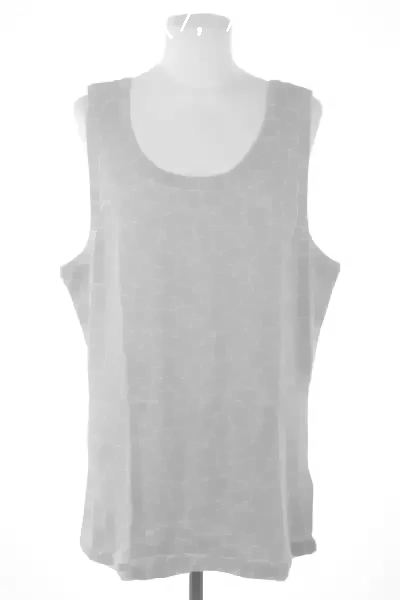

In [ ]:
# close all windows to cleanup the screen, then initialize a list of
# of kernels sizes that will be applied to the image

cv2_imshow(image)
kernelSizes = [(3, 3), (5, 5), (7, 7)]
# loop over the kernels sizes

# Pętla po rozmiarach kerneli
for kernelSize in kernelSizes:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    # Wyświetl obrazy przy użyciu cv2_imshow
    cv2_imshow(cv2.putText(
        opening,
        f"Opening: ({kernelSize[0]}, {kernelSize[1]})",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2)
    )

    cv2_imshow(opening)

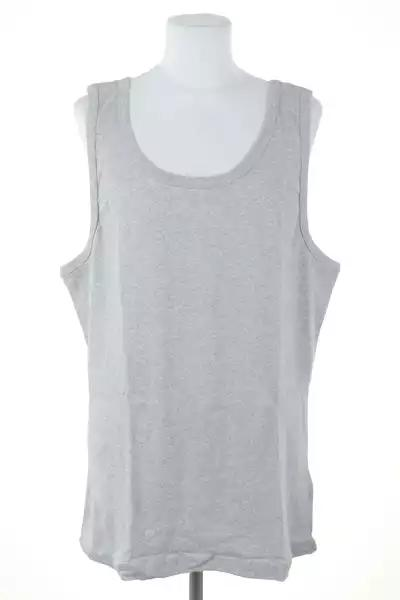

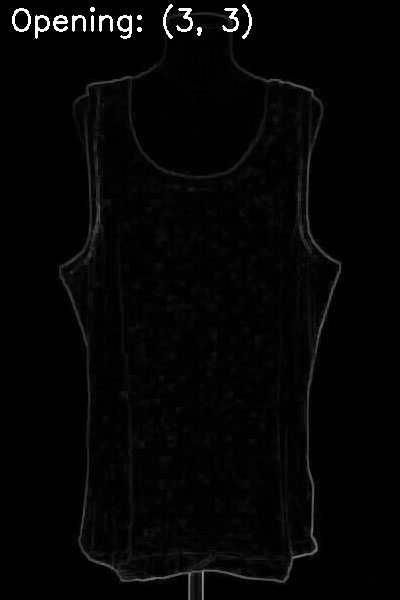

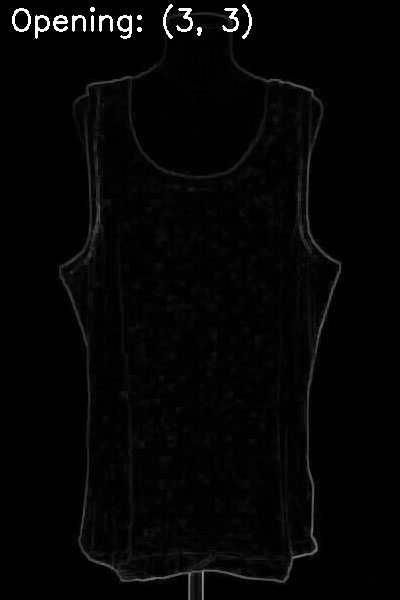

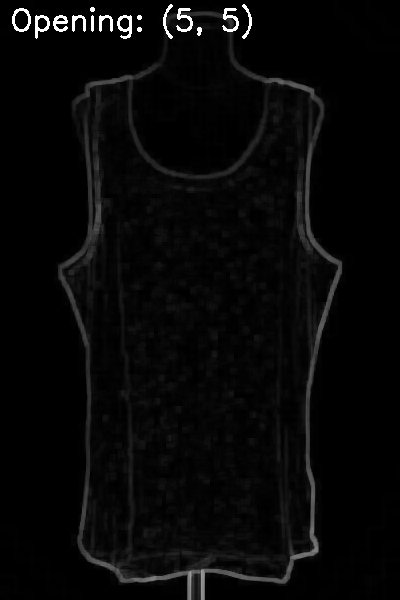

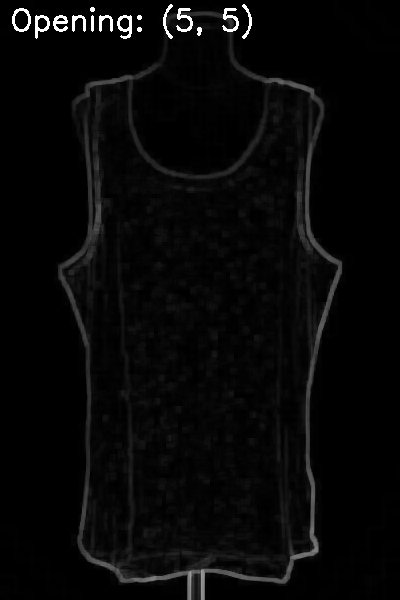

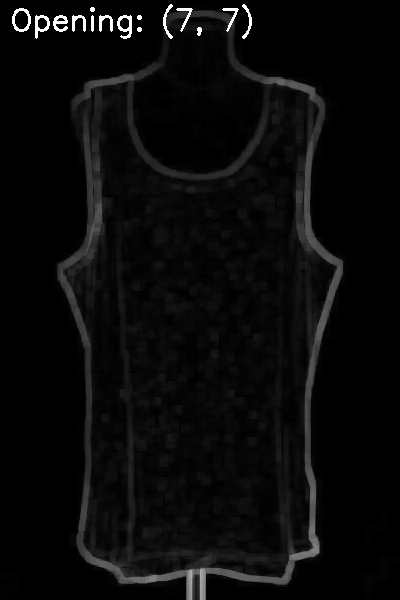

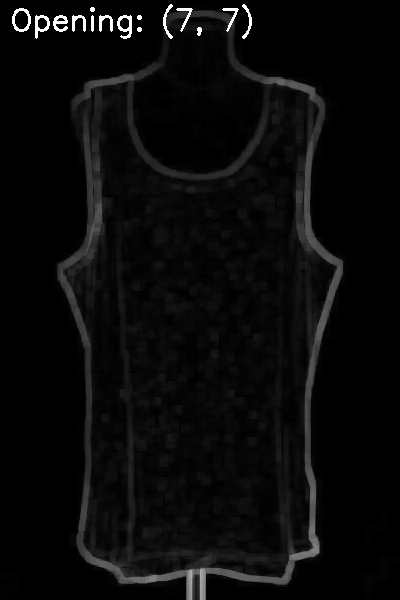

In [ ]:
# close all windows to cleanup the screen, then initialize a list of
# of kernels sizes that will be applied to the image

cv2_imshow(image)
kernelSizes = [(3, 3), (5, 5), (7, 7)]
# loop over the kernels sizes

# Pętla po rozmiarach kerneli
for kernelSize in kernelSizes:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
    opening = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

    # Wyświetl obrazy przy użyciu cv2_imshow
    cv2_imshow(cv2.putText(
        opening,
        f"Opening: ({kernelSize[0]}, {kernelSize[1]})",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2)
    )

    cv2_imshow(opening)

In [ ]:
# load the image and convert it to grayscale
image = cv2.imread(polaczone_zdjecie)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# construct a rectangular kernel (13x5) and apply a blackhat
# operation which enables us to find dark regions on a light
# background
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 12))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

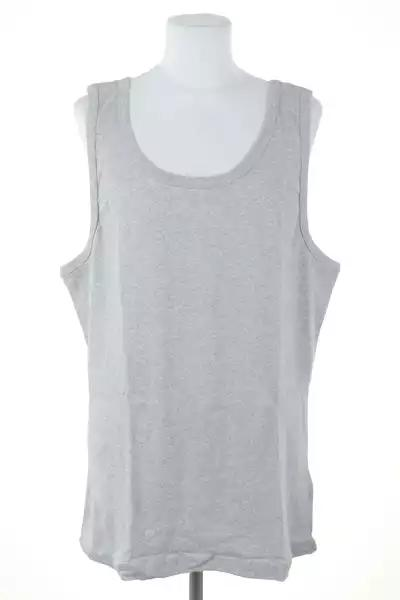

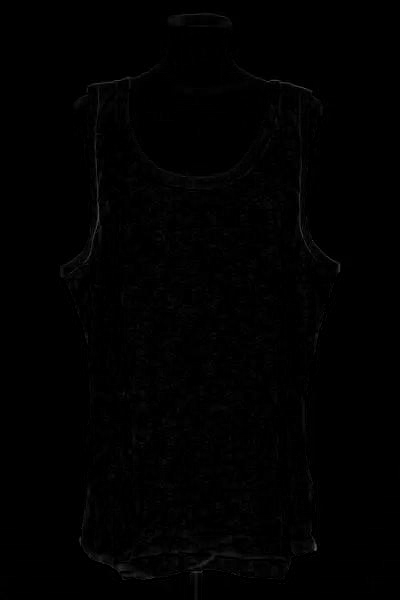

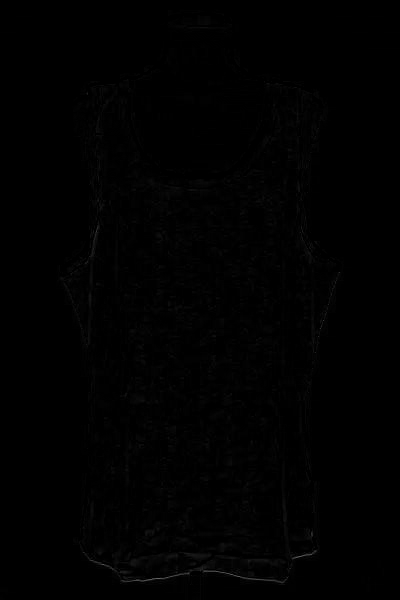

-1

In [ ]:

# similarly, a tophat (also called a "whitehat") operation will
# enable us to find light regions on a dark background
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
# show the output images
cv2_imshow(image)
cv2_imshow(blackhat)
cv2_imshow(tophat)
cv2.waitKey(0)

# Podusmowanie obrobki maski

In [184]:
from google.colab.patches import cv2_imshow
image = 'drive/MyDrive/test_maski/koszulka2.jpg'
image = cv2.imread(image)

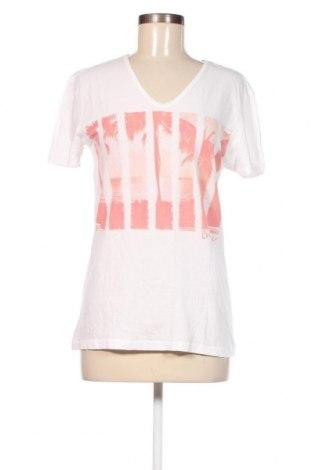

In [185]:
cv2_imshow(image)

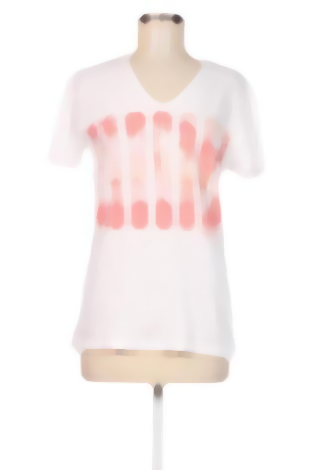

In [186]:
blurred = cv2.medianBlur(image, 11)

cv2_imshow(blurred)

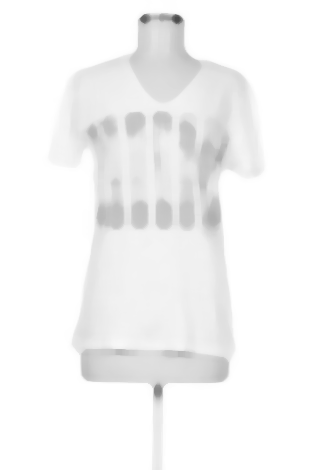

In [187]:
gray_image = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray_image)

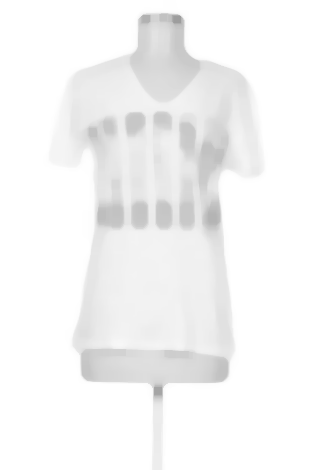

In [188]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, [7, 7])

closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

cv2_imshow(closing_equ)

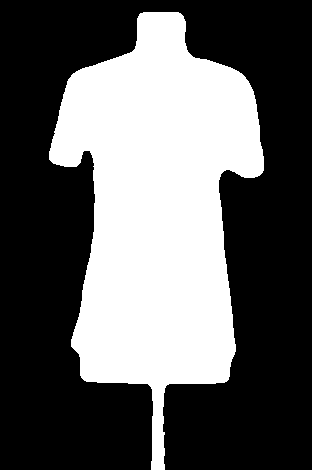

In [189]:
segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

cv2_imshow(segmented_image)

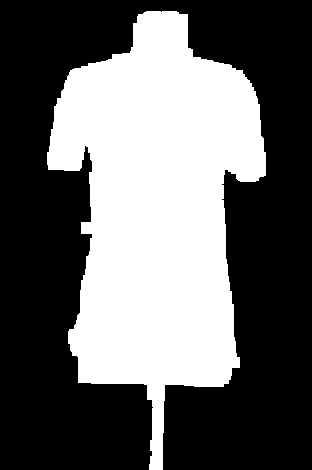

In [201]:
# PODSUMOWANIE v1
from google.colab.patches import cv2_imshow
image = 'drive/MyDrive/test_maski/koszulka2.jpg'
image = cv2.imread(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # konwersja na odcienie szarosci

equ = cv2.equalizeHist(gray_image)  # Wyrównanie histogramu

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, [11, 11])
closing_equ = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel) # morfologia zamkniecie

blurred = cv2.GaussianBlur(closing_equ, (7, 7), 0) # blurowanie w celu pozbycia sie ostrych krawedzi

(T, threshInv) = cv2.threshold(closing_equ, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) # tworzenie podzialu 0 i 1

cv2_imshow(threshInv)

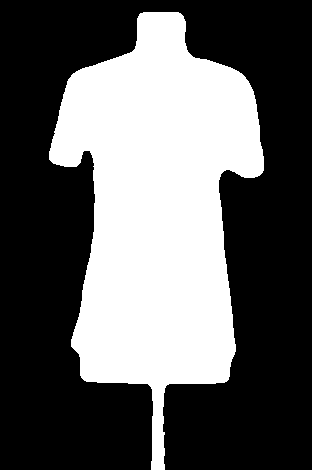

In [202]:
# PODSUMOWANIE v2

blurred = cv2.medianBlur(image, 11)

gray_image = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, [7, 7])
closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

cv2_imshow(segmented_image)


In [3]:
# Wczytanie i przygotowanie danych treningowych - zuzycie bardzo duzej ilosci pamieci
def load_data(data_folder, target_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(data_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(data_folder, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)  # Przeskalowanie do docelowej rozdzielczości
            images.append(image)


            # Generowanie adaptacyjnej maski na podstawie jasności pikseli
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # konwersja na odcienie szarosci

            equ = cv2.equalizeHist(gray_image)  # Wyrównanie histogramu

            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, [11, 11])
            closing_equ = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel) # morfologia zamkniecie

            blurred = cv2.GaussianBlur(closing_equ, (7, 7), 0) # blurowanie w celu pozbycia sie ostrych krawedzi

            (T, threshInv) = cv2.threshold(closing_equ, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) # tworzenie podzialu 0 i 1


            mask = threshInv[..., np.newaxis]   # Dodanie dodatkowego wymiaru
            masks.append(mask)


    return np.array(images), np.array(masks)

# Przygotowanie danych treningowych
data_folder = 'drive/MyDrive/ubrania_full_data/data/test/koszulki'
X_train, y_train = load_data(data_folder)

# Preprocesing obrazow

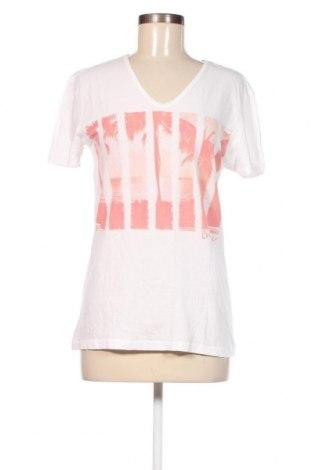

In [165]:
from google.colab.patches import cv2_imshow
image = 'drive/MyDrive/test_maski/koszulka2.jpg'
image = cv2.imread(image)

cv2_imshow(image)

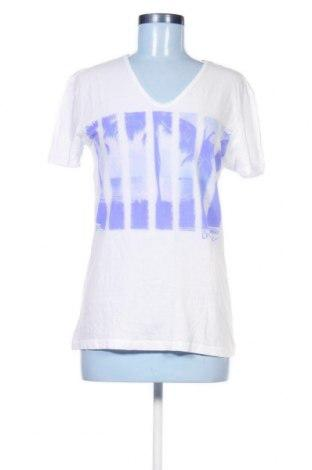

In [166]:
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_img)

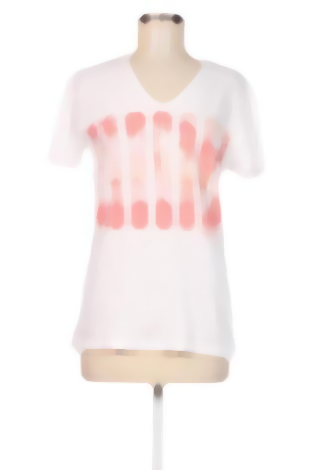

In [167]:
denoised_image = cv2.medianBlur(image, 11)
cv2_imshow(denoised_image)

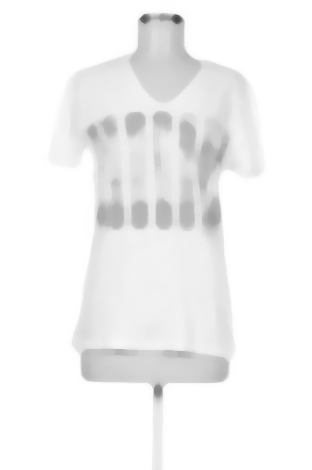

In [168]:
gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray_image)

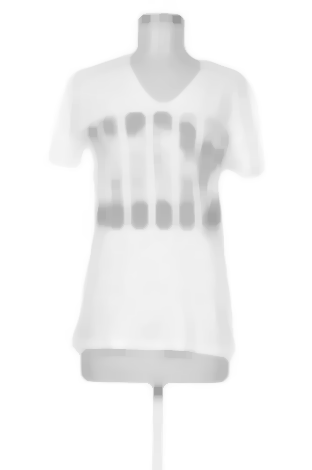

In [169]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

cv2_imshow(closing_equ)

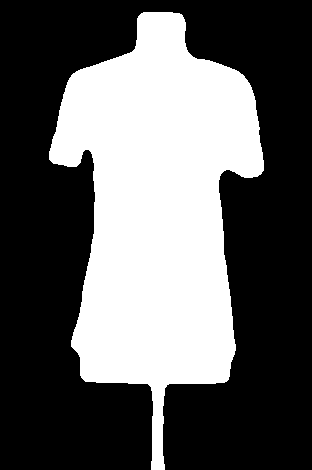

In [153]:
    # Segmentacja przez progowani

segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

cv2_imshow(segmented_image)

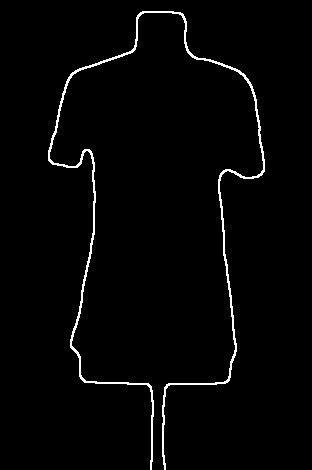

In [154]:
sobel_x = cv2.Sobel(segmented_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(segmented_image, cv2.CV_64F, 0, 1, ksize=3)
edge_image = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

cv2_imshow(edge_image)

In [ ]:
# PODSUMOWANIE v1
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

denoised_image = cv2.medianBlur(rgb_img, 11)

gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

sobel_x = cv2.Sobel(segmented_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(segmented_image, cv2.CV_64F, 0, 1, ksize=3)
edge_image = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

# testy

In [221]:
def preprocess_mask(mask, target_size):
    # Skalowanie do docelowej rozdzielczości
    mask = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)

    # Normalizacja wartości pikseli do zakresu [0, 1]
    mask = mask / 255

    return mask

In [ ]:
def load_mask(mask_path, target_size, threshold=150):
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        return preprocess_mask(mask, target_size, threshold)[..., np.newaxis]

In [100]:
def load_mask(mask_path, target_size, threshold=150):
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        return preprocess_mask(mask, target_size, threshold)[..., np.newaxis]
    else:
        return np.zeros((target_size[0], target_size[1], 1), dtype=np.uint8)

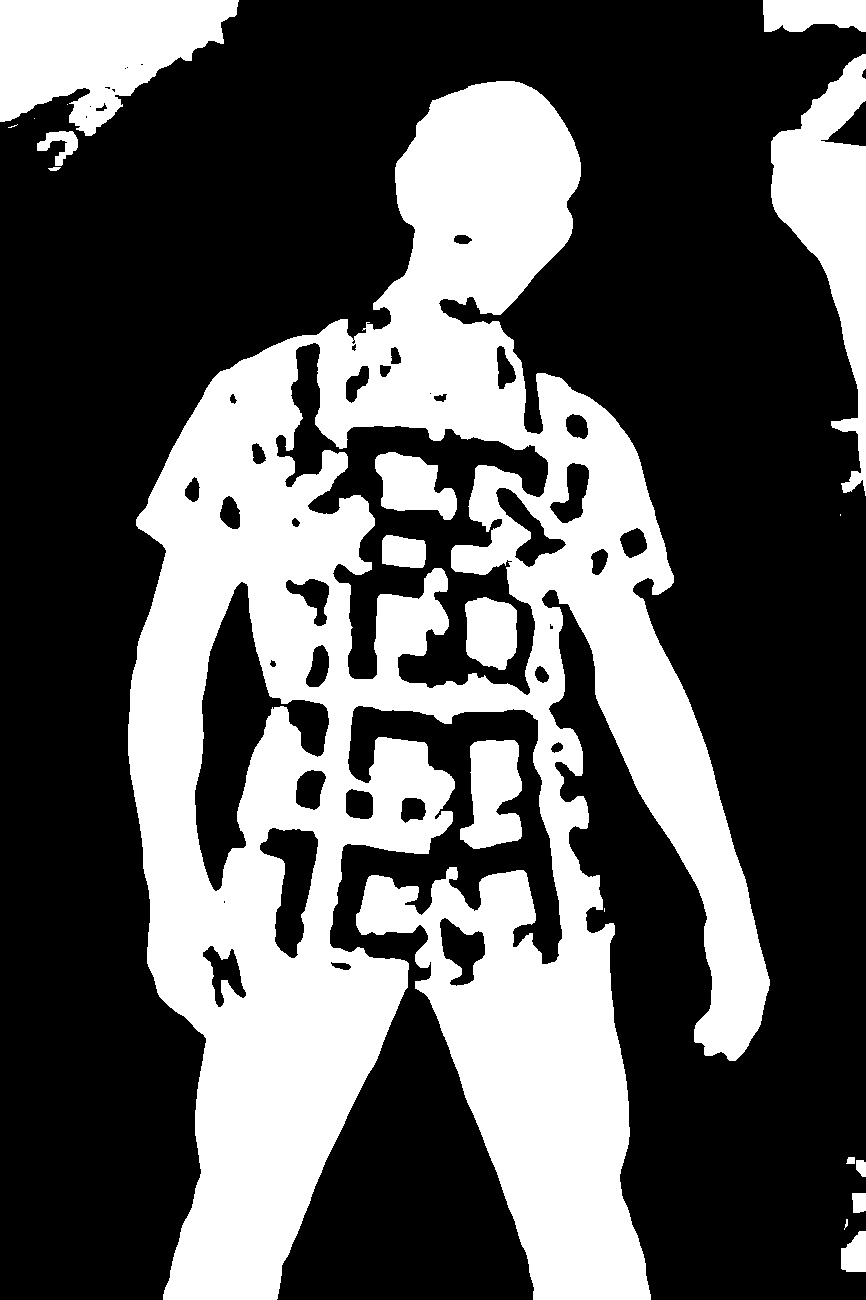

[  0   1   2   3   4   5   6   7 247 248 249 250 251 252 253 254 255]


In [96]:
from google.colab.patches import cv2_imshow
image_path = 'drive/MyDrive/test_maski/test_mask.jpg'
image = cv2.imread(image_path)

cv2_imshow(image)
unique_values = np.unique(image)

print(unique_values)

In [101]:
target_size=(256, 256)

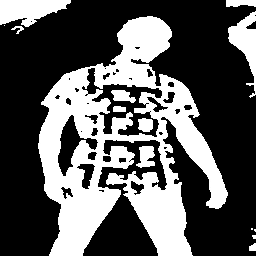

[  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]


In [64]:
mask = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)

cv2_imshow(mask)
unique_values = np.unique(mask)

print(unique_values)

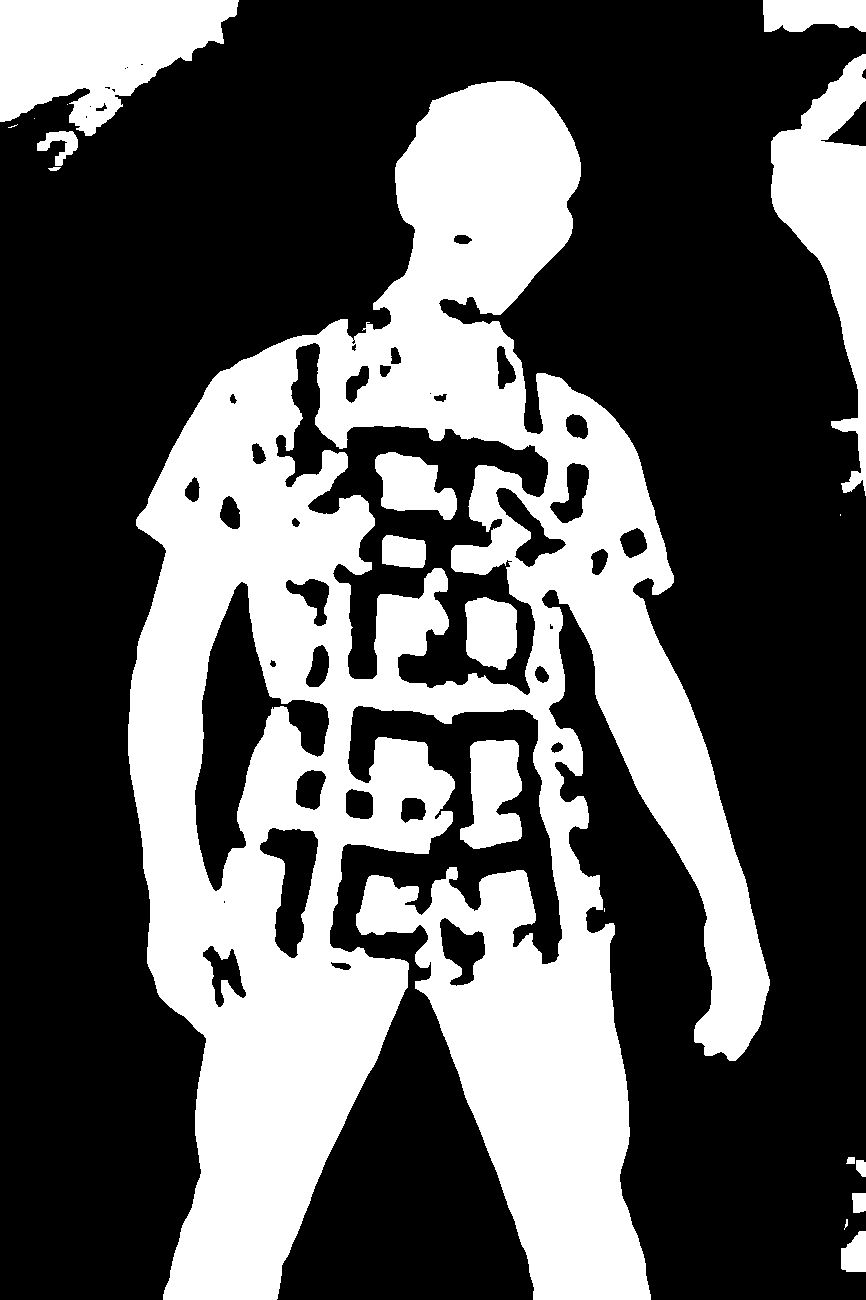

[  0 255]


In [99]:
mask = (mask > 150) * 255
mask = mask.astype(np.uint8)

cv2_imshow(mask)
unique_values = np.unique(mask)

print(unique_values)

In [75]:
mask = mask.round().astype(np.uint8)

unique_values = np.unique(mask)

print(unique_values)

[  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]


In [66]:
preprocess_mask = mask[..., np.newaxis]

In [67]:
unique_values = np.unique(preprocess_mask)

print(unique_values)

[0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.97254902 0.97647059 0.98039216 0.98431373
 0.98823529 0.99215686 0.99607843 1.        ]


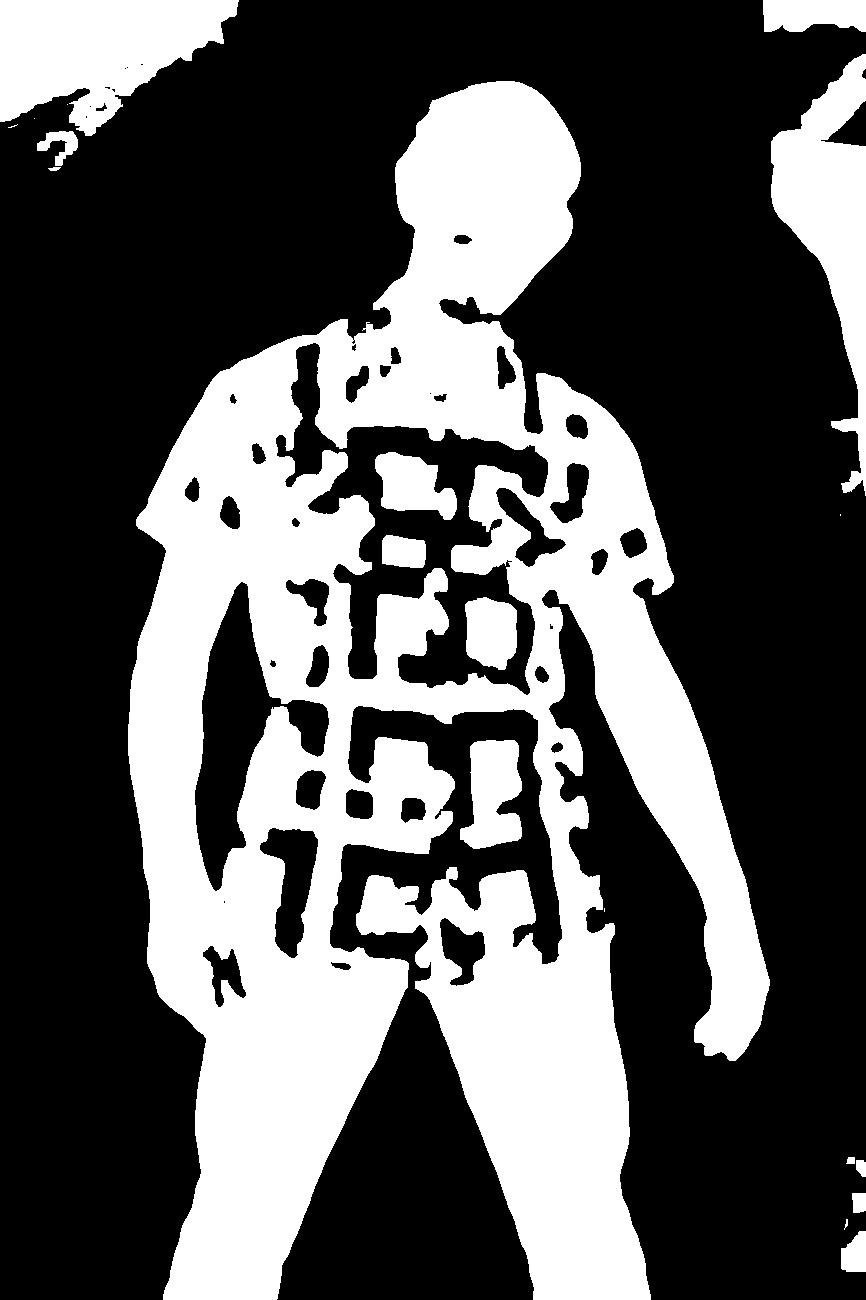

In [98]:
mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

cv2_imshow(mask)

In [69]:
mask = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)

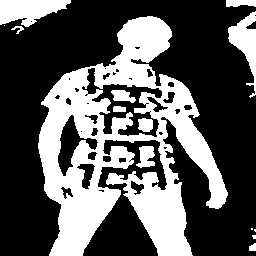

[  0 255]


In [103]:
mask = load_mask(image_path, target_size)

cv2_imshow(mask)
unique_values = np.unique(mask)

print(unique_values)

In [4]:
def generate_mask(image_path):
    mask_path = image_path.replace('.jpg', '_mask.jpg')

    image = cv2.imread(image_path)

    blurred = cv2.medianBlur(image, 11)

    gray_image = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, [7, 7])
    closing_equ = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel)

    segmented_image = cv2.adaptiveThreshold(closing_equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 401, 0)

    cv2.imwrite(mask_path, segmented_image)

In [47]:
# Inicjalizacja generatora danych dla kolorowych zdjec
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, target_size, augmentations=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.indexes = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_x = self.x[start_idx:end_idx]
        batch_y = self.y[start_idx:end_idx]

        if self.augmentations:
            batch_x, batch_y = self.apply_augmentations(batch_x, batch_y)

        return batch_x, batch_y

    def apply_augmentations(self, batch_x, batch_y):
        augmented_images = []
        augmented_masks = []
        for i in range(len(batch_x)):
            aug_image = apply_affine_transform(batch_x[i][..., 0], theta=0, tx=0, ty=0, shear=0, zx=1, zy=1, row_axis=0, col_axis=1, fill_mode='nearest', cval=0)
            aug_mask = apply_brightness_shift(batch_y[i][..., 0], brightness=0)
            augmented_images.append(np.expand_dims(aug_image, axis=-1))
            augmented_masks.append(np.expand_dims(aug_mask, axis=-1))

        return np.array(augmented_images), np.array(augmented_masks)
